In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib notebook

In [2]:
from shortfall.sim import Simulator, SimConfig
from shortfall.miners.repay_proportional import RepayProportionalShortfallMinerState
from shortfall.miners.burn import BurnShortfallMinerState
from shortfall.miners.burn_with_fee import BurnWithFeeShortfallMinerState
from shortfall.miners.repay_ratchet import RepayRatchetShortfallMinerState
from shortfall.miners.base import BaseMinerState
# from shortfall.network import *
from shortfall.network import REWARD_DECAY, BASELINE_GROWTH
from shortfall.network_mechafil import DEFAULT_NETWORK_CONFIG
from shortfall.network_mechafil import NetworkConfig as MechafilNetworkConfig
from shortfall.network_mechafil import NetworkState as MechafilNetworkState
from shortfall.network_mechafil import compute_mechafil_trajectories
from shortfall.strategy import *
from shortfall.consts import *
import shortfall.gradient.wrappers as wrappers

import dataclasses
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import matplotlib as mpl
from matplotlib.lines import Line2D

from datetime import date, timedelta

from mpl_toolkits.axes_grid1 import make_axes_locatable
import pickle
from tqdm.auto import tqdm
from ipywidgets import *

In [3]:
days = 3 * YEAR + 1
stats_interval = DAY

In [4]:
today_minus_two_days = date.today() - timedelta(days=2)
low_rbp = 3
ob_low_sa_low = compute_mechafil_trajectories(
    '/Users/kiran/code/filecoin-mecha-twin/kiran_spacescope_auth.json',
    start_date=today_minus_two_days,
    network_shortfall_rate=0.2,
    simulation_len=days+1,
    rbp=low_rbp,
    rr=0.6,
    fpr=0.8,
    sector_duration=days
)

med_rbp = 6
ob_med_sa_low = compute_mechafil_trajectories(
    '/Users/kiran/code/filecoin-mecha-twin/kiran_spacescope_auth.json',
    start_date=today_minus_two_days,
    network_shortfall_rate=0.2,
    simulation_len=days+1,
    rbp=med_rbp,
    rr=0.6,
    fpr=0.8,
    sector_duration=days
)

hi_rbp = 15
ob_hi_sa_low = compute_mechafil_trajectories(
    '/Users/kiran/code/filecoin-mecha-twin/kiran_spacescope_auth.json',
    start_date=today_minus_two_days,
    network_shortfall_rate=0.2,
    simulation_len=days+1,
    rbp=hi_rbp,
    rr=0.6,
    fpr=0.8,
    sector_duration=days
)

Computing mechafil trajectories


/opt/anaconda3/envs/cel/lib/python3.10/site-packages/pandas/core/ops/array_ops.py:73: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior. In a future version these will be considered non-comparable. Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  result = libops.scalar_compare(x.ravel(), y, op)
/opt/anaconda3/envs/cel/lib/python3.10/site-packages/pandas/core/ops/array_ops.py:73: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior. In a future version these will be considered non-comparable. Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  result = libops.scalar_compare(x.ravel(), y, op)


Finished computing mechafil trajectories
Computing mechafil trajectories


/opt/anaconda3/envs/cel/lib/python3.10/site-packages/pandas/core/ops/array_ops.py:73: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior. In a future version these will be considered non-comparable. Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  result = libops.scalar_compare(x.ravel(), y, op)
/opt/anaconda3/envs/cel/lib/python3.10/site-packages/pandas/core/ops/array_ops.py:73: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior. In a future version these will be considered non-comparable. Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  result = libops.scalar_compare(x.ravel(), y, op)


Finished computing mechafil trajectories
Computing mechafil trajectories


/opt/anaconda3/envs/cel/lib/python3.10/site-packages/pandas/core/ops/array_ops.py:73: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior. In a future version these will be considered non-comparable. Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  result = libops.scalar_compare(x.ravel(), y, op)
/opt/anaconda3/envs/cel/lib/python3.10/site-packages/pandas/core/ops/array_ops.py:73: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior. In a future version these will be considered non-comparable. Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  result = libops.scalar_compare(x.ravel(), y, op)


Finished computing mechafil trajectories


In [10]:
# global config
delta=0.1
shortfall_frac_vec = np.arange(0.0,0.4+delta,delta)
network_uptake_frac_vec = np.arange(0.0,0.4+delta,delta)
fee_structures = ['linear', 'exponential']
max_fee_frac_vec = [0.0, 0.5, 1.0]

miner_balance=0
token_lease_fee=0.0
power = 50  # noop

# burn config
max_shortfall_possible = 0.5  # noop
shortfall_pct_pow_vec = np.linspace(0,1,5)

# setup network configs
low_onboarding_network_config = \
    dataclasses.replace(DEFAULT_NETWORK_CONFIG, 
                        cil_df=ob_low_sa_low,
                        token_lease_fee=0.0)

medium_onboarding_network_config = \
    dataclasses.replace(DEFAULT_NETWORK_CONFIG, 
                        cil_df=ob_med_sa_low,
                        token_lease_fee=0.0)

high_onboarding_network_config = \
    dataclasses.replace(DEFAULT_NETWORK_CONFIG, 
                        cil_df=ob_hi_sa_low,
                        token_lease_fee=0.0)

In [11]:
savedir='/Users/kiran/Documents/hackmd/shortfall/burn_with_fees'
os.makedirs(savedir, exist_ok=True)
results_fp = os.path.join(savedir, 'results.pkl')
force_recompute=True

In [23]:
burn_with_shortfall_results = {}
base_apy_results = {}
base_takerewards_results = {}
base_no_cost_results = {}
external_borrow_rate_aer = .25
repayment_cap=1.5
take_rate=0.40

rbp_onboard_vec = [3,6,15]
networking_config_vec = [low_onboarding_network_config, medium_onboarding_network_config, high_onboarding_network_config]

if not os.path.exists(results_fp) or force_recompute:
    pbar = tqdm(total=len(shortfall_frac_vec)*len(networking_config_vec))
    for rbp_onboard, network_config in zip(rbp_onboard_vec, networking_config_vec):
        key = '%0.02f' % (rbp_onboard, )
        base_free = wrappers.compute_baseline(network_config, power, sector_duration=days, shortfall_frac=0.0)
        base_no_cost_results[key] = pd.DataFrame(data=base_free)
        for shortfall_frac in shortfall_frac_vec:
            # can be done on the fly
#             full_balance_needed = base_free[0]['balance'] + base_free[0]['pledge_locked']
#             shortfall_amt = full_balance_needed*shortfall_frac
#             key = '%0.02f,%0.02f,%0.02f' % (rbp_onboard,shortfall_frac,external_borrow_rate_aer)
#             borrow_apy_income = wrappers.compute_income_borrow_apy(base_free, shortfall_amt, 
#                                                                    external_borrow_rate_aer)
#             base_apy_results[key] = borrow_apy_income
#             key = '%0.02f,%0.02f,%0.02f,%0.02f' % (rbp_onboard,shortfall_frac,repayment_cap,take_rate)
#             borrow_rewardstake_income, _ = wrappers.compute_income_take_rewards(base_free, shortfall_amt, 
#                                                                                 repayment_cap, take_rate)
#             base_takerewards_results[key] = borrow_rewardstake_income

            for network_uptake_frac in network_uptake_frac_vec:
                for shortfall_pct_pow in shortfall_pct_pow_vec:
                    for fee_structure in fee_structures:
                        for max_fee_frac in max_fee_frac_vec:
                            # set token lease fee to 0, this simulates the scenario where the remainder of the tokens
                            # needed for pledge come from the miner's wallet
                            key = '%0.02f,%0.02f,%0.02f,%0.02f,%s,%0.02f' % \
                                (rbp_onboard,shortfall_pct_pow, shortfall_frac, network_uptake_frac, fee_structure, max_fee_frac)
                            burn_with_shortfall_df = wrappers.get_burn_stats(
                                network_config, 
                                power=power, 
                                max_shortfall_possible=max_shortfall_possible, 
                                shortfall_pct_pow=shortfall_pct_pow,
                                sector_duration=days,
                                shortfall_frac=shortfall_frac,
                                miner_balance=0,
                                network_uptake=network_uptake_frac,
                                fee_structure=fee_structure,
                                max_fee_frac=max_fee_frac
                            )
                            burn_with_shortfall_results[key] = burn_with_shortfall_df

            pbar.update(1)
            
    results_dict = {
        'burn_with_shortfall_results':burn_with_shortfall_results,
        'base_apy_results':base_apy_results,
        'base_takerewards_results':base_takerewards_results,
        'base_no_cost_results':base_no_cost_results,
        'external_borrow_rate_aer':external_borrow_rate_aer,
        'repayment_cap':repayment_cap,
        'take_rate':take_rate,
    }
    with open(results_fp, 'wb') as f:
        pickle.dump(results_dict, f)
else:
    with open(results_fp, 'rb') as f:
        results_dict = pickle.load(f)
        burn_with_shortfall_results = results_dict['burn_with_shortfall_results']
        repay_with_shortfall_results = results_dict['repay_with_shortfall_results']
        base_apy_results = results_dict['base_apy_results']
        base_takerewards_results = results_dict['base_takerewards_results']
        base_no_cost_results = results_dict['base_no_cost_results']
        external_borrow_rate_aer = results_dict['external_borrow_rate_aer']
        repayment_cap = results_dict['repayment_cap']
        take_rate = results_dict['take_rate']

  0%|          | 0/15 [00:00<?, ?it/s]

In [24]:
base_no_cost_results['%0.02f' % (15,)]

,day,power,balance,lease,pledge_locked,available,net_equity,reward_earned,fee_burned,lease_fee_accrued
0,1,0.000048,329.016421,329.016421,329.016421,0.0,0.000000,0.000000,0.0,0.0
1,2,0.000048,329.016421,328.497709,329.016421,0.0,0.518712,0.518712,0.0,0.0
2,3,0.000048,329.016421,327.982322,329.016421,0.0,1.034099,1.034099,0.0,0.0
3,4,0.000048,329.016421,327.470238,329.016421,0.0,1.546183,1.546183,0.0,0.0
4,5,0.000048,329.016421,326.961404,329.016421,0.0,2.055017,2.055017,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...
1091,1092,0.000048,329.016421,183.613075,329.016421,0.0,145.403346,145.403346,0.0,0.0
1092,1093,0.000048,329.016421,183.570978,329.016421,0.0,145.445443,145.445443,0.0,0.0
1093,1094,0.000048,329.016421,183.528932,329.016421,0.0,145.487490,145.487490,0.0,0.0
1094,1095,0.000048,329.016421,183.486936,329.016421,0.0,145.529485,145.529485,0.0,0.0


<IPython.core.display.Javascript object>


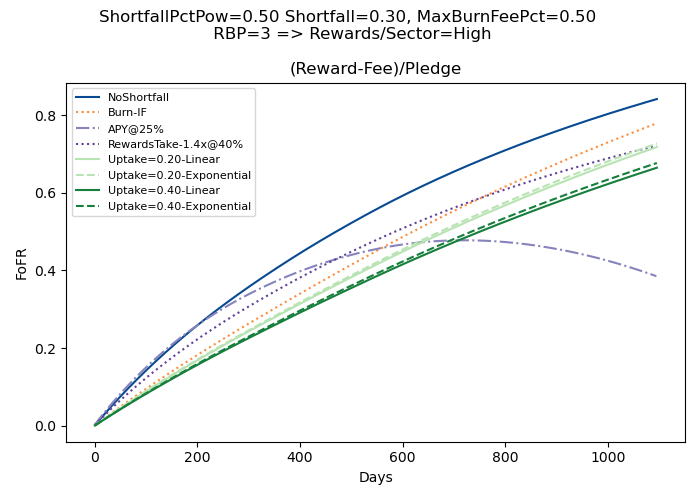

interactive(children=(FloatSlider(value=0.5, description='shortfall_pct_pow', max=1.0, step=0.25), FloatSlider…

<function __main__.update(shortfall_pct_pow=0.5, shortfall_frac=0.3, max_fee_pct=0.5, rbp=3, norm=1)>

In [26]:
colors = [mpl.colormaps['Blues'], mpl.colormaps['Oranges'], mpl.colormaps['Greens'], mpl.colormaps['Purples']]
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(7,5))
network_uptake_plot = [0.2, 0.4]

power = 50
linestyles=['-', '--', ':', '-.']
cmap_access_vec = np.linspace(0.3,0.8,len(network_uptake_plot))
def update(shortfall_pct_pow=0.5, shortfall_frac=0.3, max_fee_pct=0.5, rbp=3, norm=1):
    ax.cla()
    base_free = base_no_cost_results['%0.02f' % (rbp,)]
    norm_factor = float(base_free.iloc[0]['pledge_locked']) if norm else 1
    ax.plot(wrappers.get_income(base_free)/norm_factor, color=colors[0](0.9), label='NoShortfall')
    burn_nofees_key = '%0.02f,%0.02f,%0.02f,%0.02f,linear,%0.02f' % (rbp, shortfall_pct_pow, shortfall_frac,0,0)
    burn_nofees_df = pd.DataFrame(burn_with_shortfall_results[burn_nofees_key])
    burn_nofees_income = wrappers.get_income(burn_nofees_df) if burn_nofees_df is not None else None
    if burn_nofees_income is not None:
        norm_factor = float(burn_nofees_df.iloc[0]['pledge_locked']) if norm else 1
        ax.plot(burn_nofees_income/norm_factor, color=colors[1](0.5), linestyle=linestyles[2], label='Burn-IF')

        full_balance_needed = base_free.iloc[0]['balance'] + base_free.iloc[0]['pledge_locked']
        shortfall_amt = full_balance_needed*shortfall_frac
        borrow_apy_income = wrappers.compute_income_borrow_apy(
            base_free.to_dict('records'), shortfall_amt, external_borrow_rate_aer
        )
        borrow_take_income, _ = wrappers.compute_income_take_rewards(
            base_free.to_dict('records'), shortfall_amt, repayment_cap, take_rate
        )


    norm_factor = (base_free.iloc[0]['pledge_locked'])*(1-shortfall_frac) if norm else 1
    ax.plot(borrow_apy_income/norm_factor, color=colors[3](0.6), linestyle='-.', label='APY@25%')
    ax.plot(borrow_take_income/norm_factor, color=colors[3](0.8), linestyle=':', label='RewardsTake-1.4x@40%')

    for kk, network_uptake in enumerate(network_uptake_plot):
        burn_with_shortfall_key = '%0.02f,%0.02f,%0.02f,%0.02f,linear,%0.02f' % (rbp, shortfall_pct_pow, shortfall_frac,network_uptake,max_fee_pct)
        burn_shortfall_linear_df = pd.DataFrame(data=burn_with_shortfall_results[burn_with_shortfall_key])
        burn_shortfall_linear_income = get_income(burn_shortfall_linear_df) if burn_shortfall_linear_df is not None else None

        burn_with_shortfall_key = '%0.02f,%0.02f,%0.02f,%0.02f,exponential,%0.02f' % (rbp, shortfall_pct_pow, shortfall_frac,network_uptake,max_fee_pct)
        burn_shortfall_exp_df = pd.DataFrame(data=burn_with_shortfall_results[burn_with_shortfall_key])
        burn_shortfall_exp_income = get_income(burn_shortfall_exp_df) if burn_shortfall_exp_df is not None else None

        if burn_shortfall_linear_income is not None:
            norm_factor = float(burn_shortfall_linear_df.iloc[0]['pledge_locked']) if norm else 1
            ax.plot(burn_shortfall_linear_income/norm_factor, color=colors[2](cmap_access_vec[kk]), linestyle=linestyles[0], label='Uptake=%0.02f-Linear' % (network_uptake,))
        if burn_shortfall_exp_income is not None:
            norm_factor = float(burn_shortfall_exp_df.iloc[0]['pledge_locked']) if norm else 1
            ax.plot(burn_shortfall_exp_income/norm_factor, color=colors[2](cmap_access_vec[kk]), linestyle=linestyles[1], label='Uptake=%0.02f-Exponential' % (network_uptake,))

    ax.legend(fontsize=8)
    if norm:
        ax.set_ylabel('FoFR')
    else:
        ax.set_ylabel('Income [FIL]')
    ax.set_xlabel('Days')
    ax.set_title('(Reward-Fee)/Pledge')
    
    if rbp == 3:
        rws_str = 'High'
    elif rbp == 6:
        rws_str = 'Med'
    elif rbp == 15:
        rws_str = 'Low'
    plt.suptitle('ShortfallPctPow=%0.02f Shortfall=%0.02f, MaxBurnFeePct=%0.02f \n RBP=%d => Rewards/Sector=%s' % \
                (shortfall_pct_pow, shortfall_frac, max_fee_pct, rbp, rws_str))
    plt.tight_layout()
    fig.canvas.draw_idle()
#     plt.savefig(os.path.join(savedir, 'shortfallfrac_%0.02f-shortfallpctpow_%0.02f.png' % (shortfall_take_frac, shortfall_pct_pow)))

update()
interact(update, 
         shortfall_frac=(0.1, 0.4, 0.1),
         shortfall_pct_pow=(0,1,0.25),
         max_fee_pct=(0.0,1.0,0.5),
         rbp=[('3', 3), ('15', 15)],
         norm=[('True', 1), ('False', 0)]
)

<IPython.core.display.Javascript object>


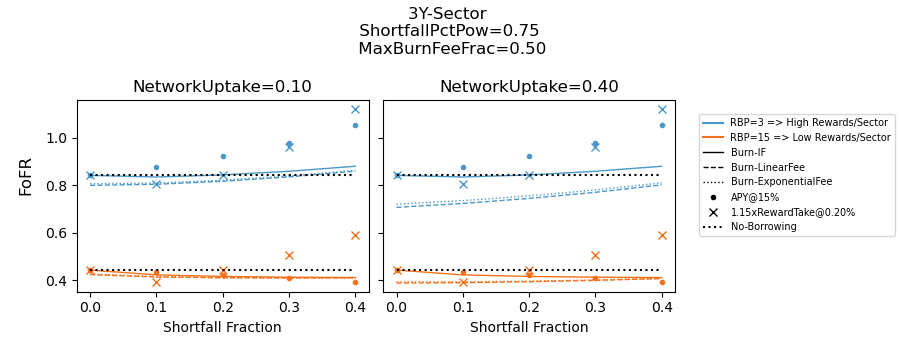

In [30]:
# make a plot of shortfall vs. FoFR for the many variants
colors = [mpl.colormaps['Blues'], mpl.colormaps['Oranges'], mpl.colormaps['Greens'], mpl.colormaps['Purples']]
linestyles=['-', '--', ':', '-.']
nrows=1
ncols=2
fig, ax = plt.subplots(nrows=nrows, ncols=ncols, figsize=(9,3.5), sharex=True, sharey=True)

# network_uptake_plot_vec = np.arange(0.1,0.4+0.1,0.1)
network_uptake_plot_vec = [0.1, 0.4]
# rbp_plot_vec = [3,6,15]
rbp_plot_vec = [3,15]
# delta=0.1
# shortfall_frac_vec = np.arange(0.0,0.4+delta,delta)

shortfall_pct_pow = 0.75  # TODO: see if you can make this into a plot
max_fee_pct = 0.5
apy_rate=0.15
reward_take_cap=1+apy_rate
reward_take_rate=0.20
norm = True
plot_utility = False

for ii, network_uptake in enumerate(network_uptake_plot_vec):
    axh = ax[ii]
    
    for jj, rbp in enumerate(rbp_plot_vec):
        base_free = base_no_cost_results['%0.02f' % (rbp,)]
        c = colors[jj]
        
        no_fees_vec = []
        linear_fees_vec = []
        exp_fees_vec = []
        apy_vec = []
        reward_take_vec = []
        for kk, shortfall_take_frac in enumerate(shortfall_frac_vec):
            burn_nofees_key = '%0.02f,%0.02f,%0.02f,0.00,linear,0.00' % (rbp, shortfall_pct_pow, shortfall_take_frac)
            burn_nofees_df = pd.DataFrame(data=burn_with_shortfall_results[burn_nofees_key])
            fofr = wrappers.get_sector_duration_fofr(burn_nofees_df,norm=norm)
            v = fofr*(1+shortfall_take_frac) if plot_utility else fofr
            no_fees_vec.append(v)
            
            burn_with_shortfall_key = '%0.02f,%0.02f,%0.02f,%0.02f,linear,%0.02f' % (rbp, shortfall_pct_pow, shortfall_take_frac,network_uptake,max_fee_pct)
            burn_shortfall_linear_df = pd.DataFrame(data=burn_with_shortfall_results[burn_with_shortfall_key])
            fofr = wrappers.get_sector_duration_fofr(burn_shortfall_linear_df,norm=norm)
            v = fofr*(1+shortfall_take_frac) if plot_utility else fofr
            linear_fees_vec.append(v)

            burn_with_shortfall_key = '%0.02f,%0.02f,%0.02f,%0.02f,exponential,%0.02f' % (rbp, shortfall_pct_pow, shortfall_take_frac,network_uptake,max_fee_pct)
            burn_shortfall_exp_df = pd.DataFrame(data=burn_with_shortfall_results[burn_with_shortfall_key])
            fofr = wrappers.get_sector_duration_fofr(burn_shortfall_exp_df,norm=norm)
            v = fofr*(1+shortfall_take_frac) if plot_utility else fofr
            exp_fees_vec.append(v)
            
            full_balance_needed = base_free.iloc[0]['pledge_locked']
            shortfall_amt = full_balance_needed*shortfall_take_frac
            
            borrow_apy_income = wrappers.compute_income_borrow_apy(
                base_free.to_dict('records'), shortfall_amt, apy_rate
            )
            borrow_take_income, _ = wrappers.compute_income_take_rewards(
                base_free.to_dict('records'), shortfall_amt, reward_take_cap, reward_take_rate
            )
            
#             borrow_apy_income = wrappers.get_base_apy_model_income(base_free.to_dict('records'), shortfall_amt, apy_rate)
#             borrow_take_income, _ = wrappers.get_revenue_take_model_income(base_free.to_dict('records'), shortfall_amt, reward_take_cap, reward_take_rate)
            norm_factor = full_balance_needed-shortfall_amt if norm else 1
            fofr = borrow_apy_income[-1]/norm_factor
            v = fofr*(1+shortfall_take_frac) if plot_utility else fofr
            apy_vec.append(v)
            fofr = borrow_take_income[-1]/norm_factor
            v = fofr*(1+shortfall_take_frac) if plot_utility else fofr
            reward_take_vec.append(v)
            
        axh.plot(shortfall_frac_vec, no_fees_vec, color=c(0.6), linestyle='-', linewidth=1, label='RBP=%d-BurnIF' % (rbp,))
        axh.plot(shortfall_frac_vec, linear_fees_vec, color=c(0.6), linestyle='--', linewidth=1, label='RBP=%d-Burn+LinearFees' % (rbp,))
        axh.plot(shortfall_frac_vec, exp_fees_vec, color=c(0.6), linestyle=':', linewidth=1, label='RBP=%d-Burn+ExponentialFees' % (rbp,))
        axh.plot(shortfall_frac_vec, apy_vec, color=c(0.6), linestyle='', marker='.', linewidth=1, label='APY@25%')
        axh.plot(shortfall_frac_vec, reward_take_vec, color=c(0.6), linestyle='', marker='x', linewidth=1, label='1.25xRewardTake@40%')
        
        base_vec = np.ones_like(shortfall_frac_vec)*wrappers.get_sector_duration_fofr(base_free)
        axh.plot(shortfall_frac_vec, base_vec, color='k', linestyle=':', linewidth=1.5, label='Base')
        
    axh.set_title('NetworkUptake=%0.02f' % (network_uptake,))
    axh.set_xlabel('Shortfall Fraction')

# compose a custom legend
custom_lines = []
text = []
for ii, rbp in enumerate(rbp_plot_vec):
    if rbp == 3:
        rbp_str = 'High Rewards/Sector'
    elif rbp == 6:
        rbp_str = 'Med Rewards/Sector'
    elif rbp == 15:
        rbp_str = 'Low Rewards/Sector'
    custom_lines.append(Line2D([0], [0], color=colors[ii](0.6))); text.append('RBP=%d => %s' % (rbp, rbp_str))
custom_lines.append(Line2D([0], [0], color='k', linewidth=1, linestyle='-'));  text.append('Burn-IF')
custom_lines.append(Line2D([0], [0], color='k', linewidth=1, linestyle='--'));  text.append('Burn-LinearFee')
custom_lines.append(Line2D([0], [0], color='k', linewidth=1, linestyle=':'));  text.append('Burn-ExponentialFee')
custom_lines.append(Line2D([0], [0], color='k', linewidth=1, linestyle='', marker='.'));  text.append('APY@%d%%' % (apy_rate*100,))
custom_lines.append(Line2D([0], [0], color='k', linewidth=1, linestyle='', marker='x'));  text.append('%0.02fxRewardTake@%0.02f%%' % (reward_take_cap, reward_take_rate))
custom_lines.append(Line2D([0], [0], color='k', linewidth=1.5, linestyle=':'));  text.append('No-Borrowing')

if norm:  
    if plot_utility:
        fig.supylabel('U')
    else:
        fig.supylabel('FoFR')
else:
    fig.supylabel('Income[FIL]')
fig.suptitle('3Y-Sector \n ShortfallPctPow=%0.02f \n MaxBurnFeeFrac=%0.02f' % (shortfall_pct_pow,max_fee_pct))
fig.legend(custom_lines, text, loc=7, fontsize=7)
plt.tight_layout()
fig.subplots_adjust(right=0.75)
prel = 'fofr' if not plot_utility else 'utility'
plt.savefig(os.path.join(savedir, '%s_pctpow_%0.02f-maxburnfee_%0.02f.png' % (prel, shortfall_pct_pow,max_fee_pct)))